In [3]:
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, cm
from IPython.display import HTML

In [4]:
num = 11
x = np.linspace(-50, 50, num)
y = np.linspace(-50, 50, num)
x, y = np.meshgrid(x, y)

In [5]:
z = x ** 2 + y ** 2

In [6]:
idx1 = np.array([[1 ,2], [2, 3]])
print(tuple(zip(*idx1)))
z[tuple(zip(*idx1))]

((1, 2), (2, 3))


array([ 2500.,  1300.])

In [7]:
z

array([[ 5000.,  4100.,  3400.,  2900.,  2600.,  2500.,  2600.,  2900.,
         3400.,  4100.,  5000.],
       [ 4100.,  3200.,  2500.,  2000.,  1700.,  1600.,  1700.,  2000.,
         2500.,  3200.,  4100.],
       [ 3400.,  2500.,  1800.,  1300.,  1000.,   900.,  1000.,  1300.,
         1800.,  2500.,  3400.],
       [ 2900.,  2000.,  1300.,   800.,   500.,   400.,   500.,   800.,
         1300.,  2000.,  2900.],
       [ 2600.,  1700.,  1000.,   500.,   200.,   100.,   200.,   500.,
         1000.,  1700.,  2600.],
       [ 2500.,  1600.,   900.,   400.,   100.,     0.,   100.,   400.,
          900.,  1600.,  2500.],
       [ 2600.,  1700.,  1000.,   500.,   200.,   100.,   200.,   500.,
         1000.,  1700.,  2600.],
       [ 2900.,  2000.,  1300.,   800.,   500.,   400.,   500.,   800.,
         1300.,  2000.,  2900.],
       [ 3400.,  2500.,  1800.,  1300.,  1000.,   900.,  1000.,  1300.,
         1800.,  2500.,  3400.],
       [ 4100.,  3200.,  2500.,  2000.,  1700.,  1600.,

In [8]:
def starting_point(shape):
    return np.array([np.random.randint(i) for i in shape])

In [92]:
#neighbor functions 

def l_inf_neighbors(point, shape):
    a = np.arange(-1, 2)
    ns = (point + np.stack(np.meshgrid(*[a for i in range(len(point))]), axis=-1)).reshape(-1, len(point))
    gt = lambda n: np.all(np.less(n, shape)) and np.all(np.greater(n, -1)) and not np.array_equal(n, point)
    return ns[[gt(n) for n in ns]]
    
# l_inf_neighbors(np.array([3, 4]), (5, 5))

def random_neighbors(number, point, shape):
    return np.hstack([np.random.randint(i, size=(number, 1)) for i in shape])   

# random_neighbors(10, [1,2,3,4], (34,4,4))

SyntaxError: non-default argument follows default argument (<ipython-input-92-db8017964b78>, line 3)

In [20]:
def greedy(f, fitter, neighbors_function):
    current = starting_point(f.shape)
    current_value = f[tuple(current)]
    better = True
    while better:
        better = False
        for neighbor in neighbors_function(current, f.shape):
            neighbor_value = f[tuple(neighbor)]
            fitter_value = fitter(current_value, neighbor_value)
            if fitter_value == neighbor_value and neighbor_value != current_value:
                yield neighbor
                current = neighbor
                current_value = neighbor_value
                better = True
                break

In [11]:
for i in greedy(z, min, l_inf_neighbors):
    print i

[9 3]
[8 2]
[7 2]
[6 2]
[5 2]
[4 3]
[5 3]
[4 4]
[5 4]
[5 5]


In [191]:
#simmulated annealing: make a random move with a probability p proportional to improvement

def get_temperature(temperature_0, decay_factor, step):
    return temperature_0 * decay_factor ** step

def nat_to_exp(q):
    max_q = max(0.0, np.max(q))
    rebased_q = q - max_q
    return np.exp(rebased_q - np.logaddexp(-max_q, np.logaddexp.reduce(rebased_q)))


def move_prob(f, current, neighbor, temperature):
    d_f = f[tuple(current)] - f[tuple(neighbor)]
    return nat_to_exp(d_f / temperature)
#     return 1 / (1 + np.exp(- d_f / temperature))
    
def simulated_annealing(f, temperature_0, decay_factor, steps, neighbor_function):
    current = starting_point(f.shape)
    yield current
    for step in range(steps):
        temperature = get_temperature(temperature_0, decay_factor, step)
        print(temperature)
        neighbor = neighbor_function(1, current, f.shape).reshape(-1)
#         print(move_prob(f, current, neighbor, temperature))
#         print(np.random.random_sample())
        if move_prob(f, current, neighbor, temperature) > np.random.random_sample():
            current = neighbor
            yield current
            
            
        
temperature_0 = 10
decay_factor = 0.99
steps = 1000

for i in simulated_annealing(z, temperature_0, decay_factor, steps, random_neighbors):
    print(i)
        
        

[8 6]
10.0
9.9
[7 4]
9.801
9.70299
[6 3]
9.6059601
9.509900499
[3 4]
9.41480149401
9.32065347907
9.22744694428
9.13517247484
9.04382075009
8.95338254259
[5 6]
8.86384871716
8.77521022999
8.68745812769
8.60058354641
8.51457771095
8.42943193384
8.3451376145
8.26168623836
8.17906937597
8.09727868221
8.01630589539
7.93614283644
7.85678140807
7.77821359399
7.70043145805
7.62342714347
7.54719287204
7.47172094332
7.39700373388
7.32303369654
7.24980335958
7.17730532598
7.10553227272
7.03447695
6.9641321805
6.89449085869
6.8255459501
6.7572904906
6.6897175857
6.62282040984
6.55659220574
6.49102628368
6.42611602085
6.36185486064
6.29823631203
6.23525394891
6.17290140942
6.11117239533
6.05006067138
5.98956006466
5.92966446401
5.87036781937
5.81166414118
5.75354749977
5.69601202477
[5 6]
5.63905190452
5.58266138548
5.52683477162
5.47156642391
5.41685075967
5.36268225207
5.30905542955
5.25596487526
5.2034052265
5.15137117424
5.0998574625
5.04885888787
4.99837029899
4.948386596
4.89890273004
4.84991

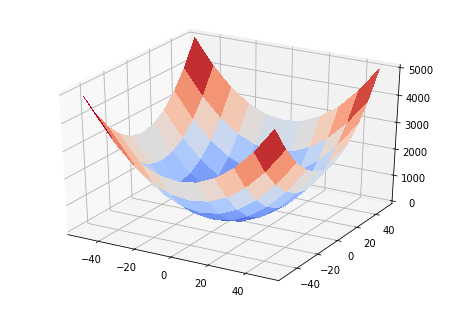

In [22]:
fig = plt.figure()
Axes3D(fig).plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [23]:
# fig = plt.figure()

# ax = Axes3D(fig)
# surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
# def init():
#     ax.view_init(elev=10., azim=0)
#     return (surf,)

# def animate(i):
#     ax.view_init(elev=10., azim=i)
#     return (surf,)

# matplotlib.rcParams['animation.writer'] = 'avconv'
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
# HTML(anim.to_html5_video())